# Set-up

Imports

In [1]:
import json
import numpy as np
import jax.numpy as jnp
import surrojax_gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
import time
sys.path.insert(0, '..')
import plotting_helpers

Plotting settings

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100

Define directory of beam data and directory of where figures are saved:

In [3]:
data_dir = '../beam/data'
fig_save_dir = './figs/gp'
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)

# Load and Transform Data

Load test and train data:

In [4]:
def load_beam_data(file_dir):
    with open(file_dir, 'r') as f:
        data = json.load(f)
    C_1 = jnp.array(data['C_1'])
    angles = jnp.array(data['beam_angle'])
    disp = jnp.array(data['end_disp'])
    x = jnp.stack([C_1, angles], axis=-1)
    y = disp.reshape(-1,1)
    C1_pts = jnp.unique(C_1.flatten())
    angle_pts = jnp.unique(angles.flatten())
    C1_grid, angle_grid = np.meshgrid(C1_pts, angle_pts)
    return {'C_1': C1_grid, 'beam_angle': angle_grid, 'end_disp': disp, 'x': x, 'y': y, 'time': jnp.array(data['t_solve'])}

train_data = load_beam_data(os.path.join(data_dir, 'neohookean_beam_training_data.json'))
test_data = load_beam_data(os.path.join(data_dir, 'neohookean_beam_test_data.json'))

Since the `C_1` and `beam_angle` parameters take on different ranges of values, it's good pratice to normalise our data using the range of values observed throughout the test and training data:

In [5]:
# For later use, let's take note of each scale factor:
def get_scale_vals(train_data, test_data, key):
    train_val, test_val = train_data[key], test_data[key]
    # Treat 'x' differently because it contains C_1 and beam_angle stacked together:
    if key == 'x':
        # Concatenate along sample dimension:
        combined = jnp.concatenate([train_val, test_val], axis=0)
        min_val = jnp.min(combined, axis=0)
        max_val = jnp.max(combined, axis=0)
    else:
        min_val = min([jnp.min(train_val), jnp.min(test_val)])
        max_val = max([jnp.max(train_val), jnp.max(test_val)])
    return min_val, max_val
disp_min, disp_max =  get_scale_vals(train_data, test_data, 'end_disp')
print(f'Displacement: min = {disp_min} mm, max = {disp_max} mm')
C1_min, C1_max =  get_scale_vals(train_data, test_data, 'C_1')
print(f'C_1: min = {C1_min} kPa, max = {C1_max} kPa')
angle_min, angle_max = get_scale_vals(train_data, test_data, 'beam_angle')
print(f'Beam angle: min = {angle_min} degrees, max = {angle_max} degrees')

Displacement: min = 0.7884718179702759 mm, max = 61.212646484375 mm
C_1: min = 1.899999976158142 kPa, max = 6.900000095367432 kPa
Beam angle: min = 0.0 degrees, max = 180.0 degrees


In [6]:
def scale_data(train_data, test_data):
    for key in train_data.keys():
        # Don't scale solution time
        if key != 'time':
            min_val, max_val = get_scale_vals(train_data, test_data, key)
            train_data[key] = (train_data[key]-min_val)/(max_val-min_val)
            test_data[key] = (test_data[key]-min_val)/(max_val-min_val)
    return train_data, test_data
train_data, test_data = scale_data(train_data, test_data)

# Define Kernel and Train

Define and train Gaussian process model - let's also time how long it takes to train the GP:

In [7]:
# Squared Exponential kernel:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)
constraints = {"length_0": {">": 0.01, "<": 1}, 
               "length_1": {">": 0.01, "<": 1}, 
               "const": {">": 0.01, "<": 1}}
print('Training GP...')
np.random.seed(42)
time_0 = time.time()
beam_gp = surrojax_gp.create_gp(kernel, train_data['x'], train_data['y'], constraints)
t_train = time.time() - time_0
print(f'Took {t_train:.2f} seconds to train GP surrogate.')

Training GP...
6692.3027
53.30949
-153.99417
-305.8072
-299.7879
-279.65707
-313.73355
-301.21164
-311.0502
-308.48358
-298.05005
-313.73355
-313.73355
-313.73355
-313.73355
-313.73355
-313.73355
-313.73355
-313.73355
-313.73355
      fun: -313.7335510253906
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -21.12841797,  283.39379883, 1139.42724609])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 5
     njev: 20
   status: 0
  success: True
        x: array([0.98858648, 0.1812361 , 0.09054732])
-125.23701
53.30949
-286.65204
-270.14673
-303.60364
-299.91083
-305.4148
-301.68707
-301.00122
-305.4148
-305.68134
-307.2591
-299.63583
-306.654
-304.74503
-307.2591
-307.2591
-307.2591
-307.2591
-307.2591
-307.2591
-307.2591
-307.2591
      fun: -307.25909423828125
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.84960175, 235.17980957, 427.85522461])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FA

Let's now save this Gaussian process model:

In [8]:
surrojax_gp.save_gp(beam_gp, "nonlinear_beam_gp")

# Predictions over Train and Test Data

Let's now plot our trained GP evaluated at the training points:

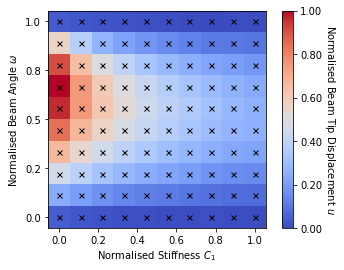

In [9]:
gp_pred = beam_gp.predict(train_data['x'])['mean']
fig = plotting_helpers.plot_gp_heatmap(train_data['C_1'], train_data['beam_angle'], gp_pred, raw_data=train_data, 
                                        z_label='Normalised Beam Tip Displacement $u$', z_lims=(0,1))
plt.savefig(os.path.join(fig_save_dir, 'gp_pred_training.svg'))
fig.show()

For the sake of comparison, let's compare this plot against the raw training data:

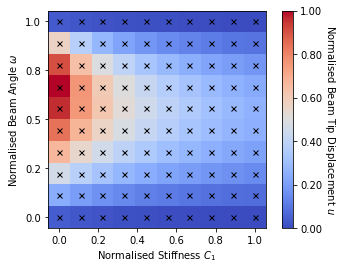

In [10]:
fig = plotting_helpers.plot_gp_heatmap(train_data['C_1'], train_data['beam_angle'], train_data['end_disp'], 
                                       raw_data=train_data,z_label='Normalised Beam Tip Displacement $u$', z_lims=(0,1))
plt.savefig(os.path.join(fig_save_dir, 'raw_training.svg'))
fig.show()

Let's now plot the GP surrogate on a much finer grid to see what it looks like; let's also time how long this takes:

1000000 predictions took 10.62859 seconds to compute (1.062859296798706e-05 seconds/simulation)


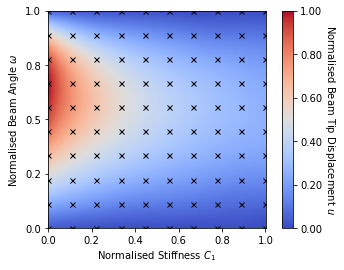

In [11]:
num_pts = 1000
C1_grid, angle_grid = plotting_helpers.create_2d_point_grid(C1_lims=(0,1), angle_lims=(0,1), 
                                                            num_C1_pts=num_pts, num_angle_pts=num_pts)
x = plotting_helpers.flatten_and_stack_grids(C1_grid, angle_grid)
time_0 = time.time()
gp_pred = beam_gp.predict(x)['mean']
time_pred = time.time() - time_0
sec_per_pred = time_pred/num_pts**2
print(f'{num_pts**2} predictions took {time_pred:.5f} seconds to compute ({sec_per_pred} seconds/simulation)')
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, gp_pred, raw_data=train_data, 
                                       z_label='Normalised Beam Tip Displacement $u$', z_lims=(0,1))
plt.savefig(os.path.join(fig_save_dir, 'gp_fine_grid.svg'))
fig.show()

Let's compare how fast our GP is relative to the full Neo-Hookean model:

In [12]:
total_time = jnp.sum(train_data['time']) + jnp.sum(test_data['time'])
total_sims = train_data['time'].size + test_data['time'].size
sec_per_sim = (total_time/total_sims)
print(f'For {total_sims} simulations, full model took {total_time/60:.2f} minutes ({sec_per_sim:.2f} seconds/simulation)')
time_diff = sec_per_sim - sec_per_pred
print(f"Speed up per simulation = {time_diff} seconds, or {100*time_diff/sec_per_sim}%.")

For 181 simulations, full model took 325.26 minutes (107.82 seconds/simulation)
Speed up per simulation = 107.82241821289062 seconds, or 100.0%.


To quantitatively evaluate the accuracy of our GP, let's use our test data set:

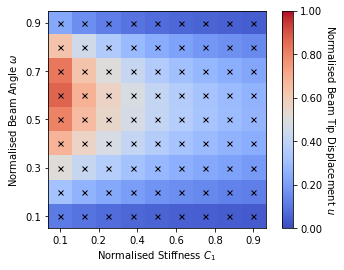

In [13]:
gp_pred = beam_gp.predict(test_data['x'])['mean']
fig = plotting_helpers.plot_gp_heatmap(test_data['C_1'], test_data['beam_angle'], test_data['end_disp'], 
                                       raw_data=test_data, z_label='Normalised Beam Tip Displacement $u$', z_lims=(0,1))
plt.savefig(os.path.join(fig_save_dir, 'gp_test.svg'))
fig.show()

Note that the training and test data points are related as follows:

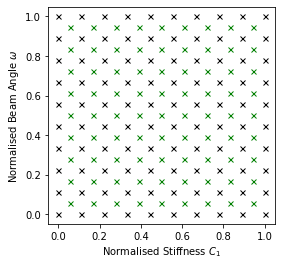

In [14]:
fig, ax = plt.subplots()
x_grid = train_data['C_1']
y_grid = train_data['beam_angle']
plotting_helpers.plot_gp_points_as_crosses(train_data, x_grid, y_grid, color='black')
plotting_helpers.plot_gp_points_as_crosses(test_data, x_grid, y_grid, color='green')
plotting_helpers.set_x_and_y_ticks(ax, train_data['C_1'], train_data['beam_angle'])
plotting_helpers.set_x_and_y_labels(ax)
plt.subplots_adjust(right=0.65)
plotting_helpers.clean_up_plot(fig)
plt.savefig(os.path.join(fig_save_dir, 'train_test_pos.svg'))
fig.show()

Comparing this against the raw test data set:

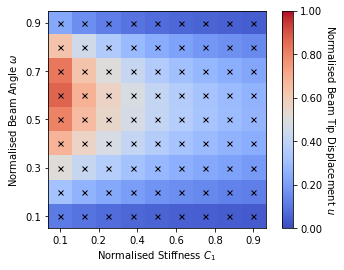

In [15]:
fig = plotting_helpers.plot_gp_heatmap(test_data['C_1'], test_data['beam_angle'], test_data['end_disp'], 
                                    raw_data=test_data, z_label='Normalised Beam Tip Displacement $u$', z_lims=(0,1))
plt.savefig(os.path.join(fig_save_dir, 'raw_test.svg'))
fig.show()

Let's now compute various errors associated with our GP model:

In [16]:
errors = jnp.abs(gp_pred - test_data['y'].squeeze())
max_error = jnp.max(errors)
avg_error = jnp.mean(errors)
median_error = jnp.median(errors)
print(f'Maximum error = {max_error} mm \n' 
      f'Average error = {avg_error} mm \n' 
      f'Median error = {median_error} mm')

Maximum error = 0.013546198606491089 mm 
Average error = 0.002277092542499304 mm 
Median error = 0.001523636281490326 mm


Let's convert these 'normalised' errors into actual displacement values:

In [17]:
disp_range = disp_max - disp_min 
print(f'Maximum error = {disp_range*max_error + disp_min} mm \n' 
      f'Average error = {disp_range*avg_error + disp_min} mm \n' 
      f'Median error = {disp_range*median_error + disp_min} mm')

Maximum error = 1.6069896221160889 mm 
Average error = 0.9260632395744324 mm 
Median error = 0.8805362582206726 mm


Let's also visualise our the errors in our GP:

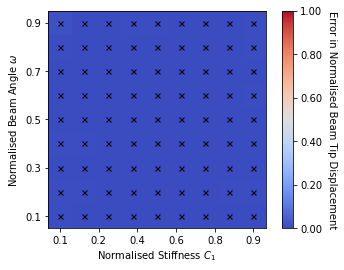

In [18]:
fig = plotting_helpers.plot_gp_heatmap(test_data['C_1'], test_data['beam_angle'], errors, raw_data=test_data,
                                       z_label='Error in Normalised Beam Tip Displacement', z_lims=(0,1))
plt.savefig(os.path.join(fig_save_dir, 'gp_error.svg'))
fig.show()

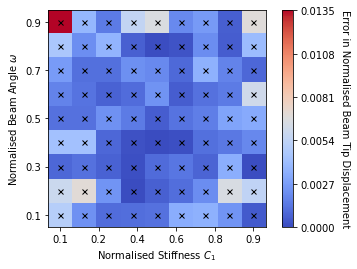

In [19]:
z_lims = (np.min(errors), np.max(errors))
fig = plotting_helpers.plot_gp_heatmap(test_data['C_1'], test_data['beam_angle'], errors, raw_data=test_data,
                                       z_label='Error in Normalised Beam Tip Displacement', z_ticks_dp=4)
plt.savefig(os.path.join(fig_save_dir, 'gp_error_zoomed.svg'))
fig.show()

# Gradient Predictions

## Mean Predictions

Let's now see what the gradients produced by our GP look like - first, the gradient wrt $C_1$:

In [20]:
num_pts = 1000
C1_grid, angle_grid = plotting_helpers.create_2d_point_grid(C1_lims=(0,1), angle_lims=(0,1), 
                                                            num_C1_pts=num_pts, num_angle_pts=num_pts)
x = plotting_helpers.flatten_and_stack_grids(C1_grid, angle_grid)

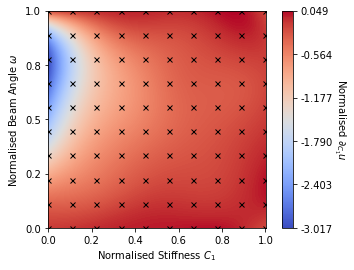

In [21]:
grad_pred = beam_gp.predict(x, grad=({'idx':[0], 'order':1},))['mean']
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, grad_pred, raw_data=train_data, 
                                       z_label='Normalised $\partial_{C_1} u$', z_ticks_dp=3)
plt.savefig(os.path.join(fig_save_dir, 'gp_dC1_pred.svg'))
fig.show()

Next, the gradient wrt the beam angle:

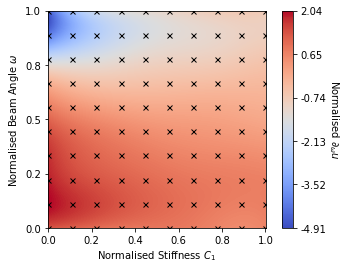

In [22]:
grad_pred = beam_gp.predict(x, grad=({'idx':[1], 'order':1},))['mean']
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, grad_pred, raw_data=train_data, 
                                       z_label='Normalised $\partial_{\omega} u$')
plt.savefig(os.path.join(fig_save_dir, 'gp_dangle_pred.svg'))
fig.show()

Next, the second derivative wrt the beam angle:

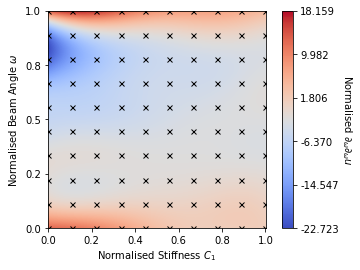

In [23]:
grad_pred = beam_gp.predict(x, grad=({'idx':[1], 'order':2},))['mean']
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, grad_pred, raw_data=train_data, z_ticks_dp=3, 
                                       z_label='Normalised $\partial_{\omega} \partial_{\omega} u$')
plt.savefig(os.path.join(fig_save_dir, 'gp_dangle2_pred.svg'))
fig.show()

Finally, the mixed derivative wrt $C_1$ and the beam angle:

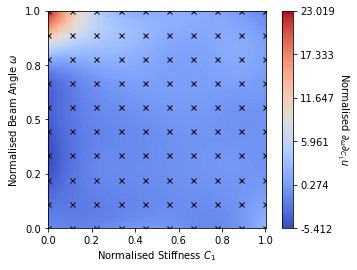

In [24]:
grad_pred = beam_gp.predict(x, grad=({'idx':[0], 'order':1}, {'idx':[1], 'order':1}))['mean']
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, grad_pred, raw_data=train_data, z_ticks_dp=3, 
                                       z_label='Normalised $\partial_{\omega} \partial_{C_1} u$')
plt.savefig(os.path.join(fig_save_dir, 'gp_dC1_dangle_pred.svg'))
fig.show()

## Variance Predictions

Since we can't easily evaluate the true error of these gradient predictions, let's instead plot their variance as predicted by the GP:

In [25]:
num_pts = 1000
C1_grid, angle_grid = plotting_helpers.create_2d_point_grid(C1_lims=(0,1), angle_lims=(0,1), 
                                                            num_C1_pts=num_pts, num_angle_pts=num_pts)
x = plotting_helpers.flatten_and_stack_grids(C1_grid, angle_grid)

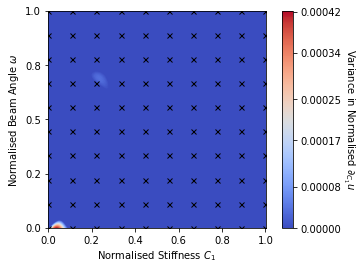

In [26]:
grad_pred = beam_gp.predict(x, grad=({'idx':[0], 'order':1},))['var']
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, grad_pred, raw_data=train_data, 
                                       z_label='Variance in Normalised $\partial_{C_1} u$', z_ticks_dp=5)
plt.savefig(os.path.join(fig_save_dir, 'gp_dC1_var.svg'))
fig.show()

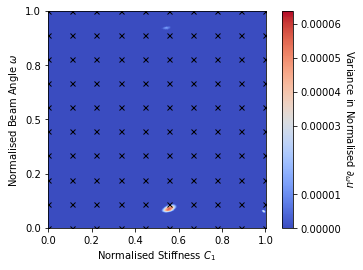

In [27]:
grad_pred = beam_gp.predict(x, grad=({'idx':[1], 'order':1},))['var']
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, grad_pred, raw_data=train_data, 
                                       z_label='Variance in Normalised $\partial_{\omega} u$',
                                       z_ticks_dp=5)
plt.savefig(os.path.join(fig_save_dir, 'gp_dangle_var.svg'))
fig.show()

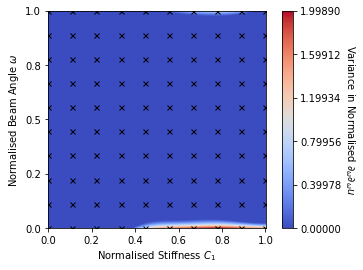

In [28]:
grad_pred = beam_gp.predict(x, grad=({'idx':[1], 'order':2},))['var']
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, grad_pred, raw_data=train_data, z_ticks_dp=5, 
                                       z_label='Variance in Normalised $\partial_{\omega} \partial_{\omega} u$')
plt.savefig(os.path.join(fig_save_dir, 'gp_dangle2_var.svg'))
fig.show()

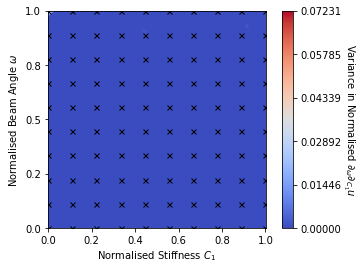

In [29]:
grad_pred = beam_gp.predict(x, grad=({'idx':[0], 'order':1}, {'idx':[1], 'order':1}))['var']
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, grad_pred, raw_data=train_data, z_ticks_dp=5, 
                                       z_label='Variance in Normalised $\partial_{\omega} \partial_{C_1} u$')
plt.savefig(os.path.join(fig_save_dir, 'gp_dC1_dangle_var.svg'))
fig.show()

# The Dangers of Extrapolation

Unless we provide a kernel which is specific to our problem, GPs are inherently interpolatory algorithms - expolating with them is dangerous. To see this, let's evaluate the mean and variance of our GP outside the training data bounds:

In [30]:
num_pts = 1000
C1_grid, angle_grid = plotting_helpers.create_2d_point_grid(C1_lims=(-1,2), angle_lims=(-1,2), 
                                                            num_C1_pts=num_pts, num_angle_pts=num_pts)
x = plotting_helpers.flatten_and_stack_grids(C1_grid, angle_grid)
time_0 = time.time()
gp_pred = beam_gp.predict(x)

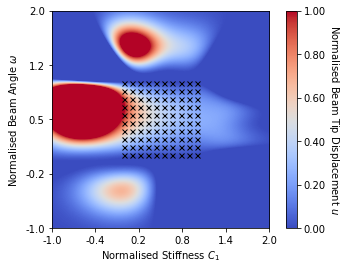

In [31]:
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, gp_pred['mean'], raw_data=train_data, 
                                       z_label='Normalised Beam Tip Displacement $u$', z_lims=(0,1))
plt.savefig(os.path.join(fig_save_dir, 'gp_extrapolate_mean.svg'))
fig.show()

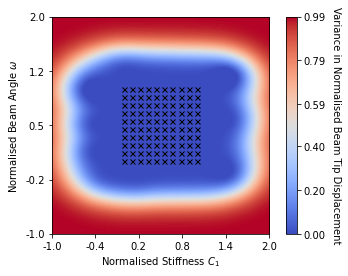

In [32]:
fig = plotting_helpers.plot_gp_heatmap(C1_grid, angle_grid, gp_pred['var'], raw_data=train_data, 
                                       z_label='Variance in Normalised Beam Tip Displacement')
plt.savefig(os.path.join(fig_save_dir, 'gp_extrapolate_var.svg'))
fig.show()